### imports

In [1]:
from tpot import TPOTClassifier, TPOTRegressor
import dill
import pandas as pd

from configparser import ConfigParser
import numerapi
import os
import sys
if not os.getcwd().endswith('trading'): os.chdir('../../../../trading') # local machine
assert os.getcwd().endswith('trading'), 'Wrong path!'
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from collections import Counter
from skimpy import clean_columns

import multiprocessing as mp
from sklearn.metrics import mean_squared_error
from pandarallel import pandarallel # parallel pandas
import time
import numpy as np
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer

import platform
from datetime import datetime
from sklearn.base import TransformerMixin
if platform.system() != 'Windows':
    mp.set_start_method('forkserver')
sys.path.append(os.getcwd())
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### load the model

In [5]:
model_dict = dill.load(open('/media/melgazar9/HDD_10TB/trading/objects/XGBRegressor_2022-03-17_16_28_00.pkl', 'rb'))

In [6]:
model_dict.keys()

dict_keys(['model', 'df_pred', 'feature_creator', 'feature_transformer', 'input_features', 'final_features', 'final_dtype_mapping', 'dropped_features', 'input_df'])

### global variables

In [7]:
print('\nTrain xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['target_20d']))))

print('Train xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['target_20d']))))

print('Train xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['target_20d']))))



Train xgboost RMSE: 0.21952151803234238

Train xgboost RMSE: 0.21672828832361798

Train xgboost RMSE: 0.21214639522304019



In [8]:
model_dict['df_pred'][['XGBRegressor_pred']].describe()

,XGBRegressor_pred
count,1341495.00000
mean,0.50458
std,0.03052
min,0.19821
25%,0.48830
50%,0.50438
75%,0.52005
max,0.82168


<AxesSubplot:ylabel='Frequency'>

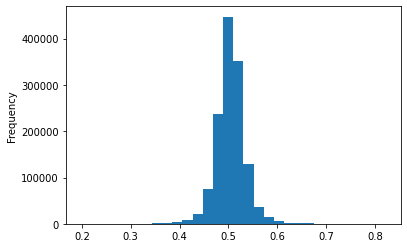

In [9]:
model_dict['df_pred']['XGBRegressor_pred'].plot(kind='hist', bins=30)

<AxesSubplot:ylabel='Frequency'>

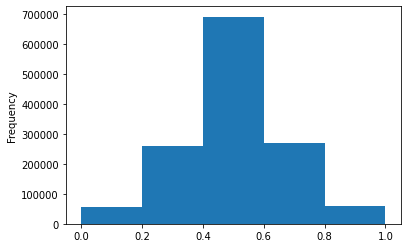

In [11]:
model_dict['df_pred']['target_20d'].plot(kind='hist', bins=5)

## Core numerai signals evaluation metrics
These metrics determine how good the model really is and gives a solid estimation on how much we will get paid out if we deployed this particular model

In [25]:
def calculate_fnc(sub, targets, features):
    """    
    Args:
        sub (pd.Series)
        targets (pd.Series)
        features (pd.DataFrame)
    """

    # Normalize submission
    sub = (sub.rank(method="first").values - 0.5) / len(sub)

    # Neutralize submission to features
    f = features.values
    sub -= f.dot(np.linalg.pinv(f).dot(sub))
    sub /= sub.std()

    sub = pd.Series(np.squeeze(sub)) # Convert np.ndarray to pd.Series

    # FNC: Spearman rank-order correlation of neutralized submission to target
    fnc = np.corrcoef(sub.rank(pct=True, method="first"), targets)[0, 1]

    return fnc

In [22]:
class CalcNumeraiMetrics:
    
    def __init__(self, y, y_pred):
        self.y = y
        self.y_pred = y_pred
    
    def calc_coef(self):

        # method="first" breaks ties based on order in array
        return np.corrcoef(self.y, self.y_pred.rank(pct=True, method="first"))[0,1]
    
    def calc_mmc(self):
        pass
    
    def calc_estimated_payout(self, stake_value, payout_factor, corr, corr_multiplier, mmc, mmc_multiplier):
        estimated_payout = stake_value * payout_factor * (corr * corr_multiplier + mmc * mmc_multiplier)
        return estimated_payout
    
    def calc_all_metrics(self):
        coef = self.calc_coef()
        metric_summary = {'coef': coef}
        return metric_summary

In [23]:
print('train corr_coef best:', CalcNumeraiMetrics(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['XGBRegressor_pred'], model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['XGBRegressor_pred']).calc_all_metrics())
print('train corr_coef actual:', CalcNumeraiMetrics(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['XGBRegressor_pred'], model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['target_20d']).calc_all_metrics())
print('val corr_coef best:', CalcNumeraiMetrics(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['XGBRegressor_pred'], model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['XGBRegressor_pred']).calc_all_metrics())
print('val corr_coef actual:', CalcNumeraiMetrics(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['XGBRegressor_pred'], model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['target_20d']).calc_all_metrics())
print('test corr_coef best:', CalcNumeraiMetrics(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['XGBRegressor_pred'], model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['XGBRegressor_pred']).calc_all_metrics())
print('test corr_coef actual:', CalcNumeraiMetrics(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['XGBRegressor_pred'], model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['target_20d']).calc_all_metrics())

train corr_coef best: {'coef': 0.9035467765291023}
train corr_coef actual: {'coef': 0.008000535106365784}
val corr_coef best: {'coef': 0.9030306109612434}
val corr_coef actual: {'coef': 0.01004697853094071}
test corr_coef best: {'coef': 0.9034913733196552}
test corr_coef actual: {'coef': -0.003531597960824528}


### Upload Predictions

In [28]:
import argparse
import os
import pandas as pd
from halo import Halo
from sklearn.ensemble import GradientBoostingRegressor

TARGET_NAME = 'target_20d'
PREDICTION_NAME = 'XGBRegressor_pred'

spinner = Halo(text='', spinner='dots')

In [33]:
spinner.start('Reading data')
train = pd.read_csv('/home/melgazar9/Downloads/latest_signals_dataset/example_training_data_yahoo.csv')
tournament = pd.read_csv('/home/melgazar9/Downloads/latest_signals_dataset/example_tournament_data_yahoo.csv')
spinner.succeed()

✔ Reading data⠙ Reading data⠹ Reading data⠸ Reading data⠼ Reading data⠴ Reading data⠦ Reading data⠧ Reading data⠇ Reading data⠏ Reading data⠋ Reading data⠙ Reading data⠹ Reading data⠸ Reading data⠼ Reading data⠴ Reading data⠦ Reading data⠧ Reading data⠇ Reading data⠏ Reading data⠋ Reading data⠙ Reading data⠹ Reading data⠸ Reading data⠼ Reading data⠴ Reading data⠦ Reading data⠧ Reading data⠇ Reading data⠏ Reading data⠋ Reading data⠙ Reading data⠹ Reading data⠸ Reading data⠼ Reading data⠴ Reading data⠦ Reading data⠧ Reading data⠇ Reading data⠏ Reading data⠋ Reading data⠙ Reading data⠹ Reading data⠸ Reading data⠼ Reading data⠴ Reading data⠦ Reading data⠧ Reading data⠇ Reading data⠏ Reading data⠋ Reading data⠙ Reading data⠹ Reading data⠸ Reading data⠼ Reading data⠴ Reading data⠦ Reading data⠧ Reading data⠇ Reading data⠏ Reading data⠋ Reading data⠙ Reading data⠹ Reading data⠸ Reading data⠼ Reading data⠴ Reading data⠦ Reading data⠧ Reading data⠇ Reading data⠏ Reading data⠋ Reading data⠙ Read

In [58]:
from sklearn.decomposition import PCA

In [73]:
tmp = Pipeline(steps=[
    ('pca', PCA(n_components=)),
    ('model', XGBRegressor(colsample_bytree=0.8,
                         gamma=0.01,
                         learning_rate=0.05,
                         max_depth=5,
                         min_child_weight=1,
                         n_estimators=100,
                         n_jobs=NUM_WORKERS,
                         random_state=0,
                         subsample=0.7))
                     ]).fit(train[['feature_RSI_14_adj_close_quintile_lag_1',
       'feature_RSI_14_adj_close_quintile_lag_2',
       'feature_RSI_14_adj_close_quintile_lag_3',
       'feature_RSI_14_adj_close_quintile_lag_4',
       'feature_RSI_14_adj_close_quintile_lag_5']], train['target_20d'])

<AxesSubplot:ylabel='Frequency'>

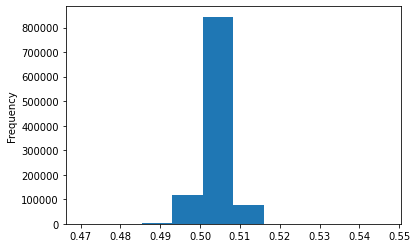

In [75]:
preds = tmp.predict(train[['feature_RSI_14_adj_close_quintile_lag_1',
       'feature_RSI_14_adj_close_quintile_lag_2',
       'feature_RSI_14_adj_close_quintile_lag_3',
       'feature_RSI_14_adj_close_quintile_lag_4',
       'feature_RSI_14_adj_close_quintile_lag_5']])
pd.Series(preds).plot(kind='hist')

In [76]:
tournament.isnull().sum()[tournament.isnull().sum()>0]

friday_date     5391
data_type       5391
target_4d       5391
target_20d     23974
target          5391
dtype: int64

In [77]:
tournament['data_type'].fillna('live', inplace=True)

In [81]:
model_dict['df_pred']

date bloomberg_ticker yahoo_ticker  adj_close_1d  \
bloomberg_ticker                                                              
000060 KS        0   2015-02-06        000060 KS    000060.KS    9012.48633   
                 1   2015-02-13        000060 KS    000060.KS    9084.87500   
                 2   2015-02-27        000060 KS    000060.KS    9483.01660   
                 3   2015-03-06        000060 KS    000060.KS    8903.90137   
                 4   2015-03-13        000060 KS    000060.KS    8650.53711   
...                         ...              ...          ...           ...   
ZZZ CN           187 2021-12-10           ZZZ CN       ZZZ.TO      37.16832   
                 188 2021-12-17           ZZZ CN       ZZZ.TO      36.61164   
                 189 2021-12-24           ZZZ CN       ZZZ.TO      37.32737   
                 190 2021-12-31           ZZZ CN       ZZZ.TO      37.30749   
                 191 2022-01-07           ZZZ CN       ZZZ.TO      36.44265   

                        close_1d     high_1d      low_1d     open_1d  \
bloomberg_ticker                                                       
000060 KS        0   12450.00000 12550.00000 12300.00000 12400.00000   
                 1   12550.00000 12550.00000 12350.00000 12500.00000   
                 2   13100.00000 13700.00000 12950.00000 13700.00000   
                 3   12300.00000 12550.00000 12200.00000 12500.00000   
                 4   11950.00000 12300.00000 11900.00000 12200.00000   
...                          ...         ...         ...         ...   
ZZZ CN           187    37.39000    38.03000    37.15000    38.03000   
                 188    36.83000    37.02000    35.69000    35.83000   
                 189    37.55000    37.76000    37.28000    37.50000   
                 190    37.53000    37.61000    37.10000    37.37000   
                 191    36.66000    36.89000    35.73000    36.50000   

                        volume_1d            date_localized  ...  \
bloomberg_ticker                                             ...   
000060 KS        0   230705.00000 2015-02-05 18:00:00-06:00  ...   
                 1   213433.00000 2015-02-12 18:00:00-06:00  ...   
                 2   340504.00000 2015-02-26 18:00:00-06:00  ...   
                 3   424563.00000 2015-03-05 18:00:00-06:00  ...   
                 4   572364.00000 2015-03-12 19:00:00-05:00  ...   
...                           ...                       ...  ...   
ZZZ CN           187  49800.00000 2021-12-09 18:00:00-06:00  ...   
                 188  98200.00000 2021-12-16 18:00:00-06:00  ...   
                 189  14000.00000 2021-12-23 18:00:00-06:00  ...   
                 190  32200.00000 2021-12-30 18:00:00-06:00  ...   
                 191  68300.00000 2022-01-06 18:00:00-06:00  ...   

                      high_move_pct_1h_14_ewm_mean  \
bloomberg_ticker                                     
000060 KS        0                             NaN   
                 1                             NaN   
                 2                             NaN   
                 3                             NaN   
                 4                             NaN   
...                                            ...   
ZZZ CN           187                       0.00254   
                 188                       0.00103   
                 189                       0.00103   
                 190                       0.00727   
                 191                       0.00321   

                      high_move_pct_change_1h_14_ewm_mean  \
bloomberg_ticker                                            
000060 KS        0                                    NaN   
                 1                                    NaN   
                 2                                    NaN   
                 3                                    NaN   
                 4                                    NaN   
...                                            

In [84]:
model_dict['df_pred'][['date', 'bloomberg_ticker']].reset_index(drop=True)

,date,bloomberg_ticker
0,2015-02-06,000060 KS
1,2015-02-13,000060 KS
2,2015-02-27,000060 KS
3,2015-03-06,000060 KS
4,2015-03-13,000060 KS
...,...,...
1341490,2021-12-10,ZZZ CN
1341491,2021-12-17,ZZZ CN
1341492,2021-12-24,ZZZ CN
1341493,2021-12-31,ZZZ CN


In [93]:
model_dict['df_pred'].reset_index(drop=True, inplace=True)

In [89]:
tournament['date'] = pd.to_datetime(tournament['date'])

In [98]:
df_live = pd.merge(tournament[tournament['data_type']=='live'][['date', 'bloomberg_ticker']], model_dict['df_pred'], on=['date', 'bloomberg_ticker'])

In [99]:
df_live

,date,bloomberg_ticker,yahoo_ticker,adj_close_1d,close_1d,high_1d,low_1d,open_1d,volume_1d,date_localized,...,high_move_pct_1h_14_ewm_mean,high_move_pct_change_1h_14_ewm_mean,low_move_1h_14_ewm_mean,low_move_pct_1h_14_ewm_mean,low_move_pct_change_1h_14_ewm_mean,move_1d_iar_ewm_mean,high_move_1d_iar_ewm_mean,low_move_1d_iar_ewm_mean,dataset_split,XGBRegressor_pred


In [97]:
tournament.shape, df_live.shape, model_dict['df_pred'][model_dict['df_pred']['dataset_split'].isin(['val', 'test'])].shape

((1645216, 88), (1294835, 917), (405290, 917))